# import library

In [2]:
options(width = 222)
library(data.table)
library(ggpubr)
library(survminer)
library(survival)
library(org.Hs.eg.db)


# import ecog data

In [3]:
gpl = fread("~/ecog/GPL6602-433.txt", header=T)
setnames(gpl, 'ID', 'NimblGen')
#colnames(gpl) = c('NimblGen', 'ACCNUM')
 
res = select(org.Hs.eg.db, keys=gpl$GB_ACC, columns=c("SYMBOL", "GENENAME", "ENSEMBL", "ACCNUM"), keytype="ACCNUM")
gpl.id = merge(gpl, res, by.x = 'GB_ACC', by.y = "ACCNUM")
#gpl.id[SYMBOL == 'BCAT2',]
# SLC7A5 (LAT1), SLC3A2, SLC16A19, SLC16A1 (MCT1), SLC16A3 (MCT4), SLC25A44
#genes = c('SLC7A5', 'SLC3A2', 'SLC16A19', 'SLC16A1', 'SLC16A3', 'SLC25A44')
#gpl.id[SYMBOL %in% genes, ]
#id = unique(gpl.id[SYMBOL %in% genes, NimblGen])
head(gpl.id[, .(SYMBOL, NimblGen)])


'select()' returned many:many mapping between keys and columns



SYMBOL,NimblGen
<chr>,<chr>
FAM193A,HSAP0406S00008350
GDF15,HSAP0406S00031788
KNDC1,HSAP0406S00019266
SLC15A1,HSAP0406S00023942
SHC2,HSAP0406S00030877
TRPM2,HSAP0406S00034573


In [7]:
ecog_dt = fread('~/ecog/ecog1900_expression_outcomes.txt')
# genotype mutation
#ecog_dt[1:10, 1:33]

# clinical information
#ecog_dt[1:10, 34:59]

# gene expression, NimbelGen
#ecog_dt[1:10, 60:89]
 
#mtx_meta = ecog_dt[6:324, 5:8]
#mtx_exp = ecog_dt[6:324, id, with=F]


In [53]:
ecog_dt[1:10, 1:10]

Filename,filename_old,EcogID_old,chip_id_old,SampleID_old,tumor_normal,Age,Sex1F2M,ChemDoseAHiBLo,IDH1
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
GSM603784.pair,GSM603784,?,?,NBM_GE_1,n,?,?,?,?
GSM603785.pair,GSM603785,?,?,NBM_GE_2,n,?,?,?,?
GSM603786.pair,GSM603786,?,?,NBM_GE_3,n,?,?,?,?
GSM603787.pair,GSM603787,?,?,NBM_GE_4,n,?,?,?,?
GSM603788.pair,GSM603788,?,?,NBM_GE_5,n,?,?,?,?
GSM603783.pair,GSM603783,13479,402146,AML_GE_1,t,59,1,A,WT
GSM603678.pair,GSM603678,13986,342240,AML_GE_5,t,26,2,A,WT
GSM603642.pair,GSM603642,14026,264994,AML_GE_7,t,36,2,B,WT
GSM603840.pair,GSM603840,14055,29023402,AML_GE_8,t,52,2,B,WT


In [9]:
table(ecog_dt$tumor_normal)


  n   t 
  5 319 

In [10]:
table(ecog_dt$IDH1)



    ? R132C R132H R132S  V71I    WT 
    5     6    11     1     1   300 

In [11]:
mtx_gt = ecog_dt[1:324, 10:39]
for(ii in colnames(mtx_gt)){
    wt_gt = paste0(ii, '\nWT')
    mt_gt = paste0(ii, '\nMT')
    mtx_gt[get(ii) != 'WT', (ii) := mt_gt]
    mtx_gt[get(ii) == 'WT', (ii) := wt_gt]
    mtx_gt[1:5, (ii) := 'Norm'] 
    mtx_gt[, (ii) := factor(get(ii), levels = c('Norm', wt_gt, mt_gt))]
}
ecog_gt_dt = cbind(ecog_dt[, 1:9], mtx_gt, ecog_dt[, 40:ncol(ecog_dt)])


In [12]:
head(ecog_gt_dt)

Filename,filename_old,EcogID_old,chip_id_old,SampleID_old,tumor_normal,Age,Sex1F2M,ChemDoseAHiBLo,IDH1,⋯,HSAP0406S00037356,HSAP0406S00037357,HSAP0406S00037358,HSAP0406S00037359,HSAP0406S00037360,HSAP0406S00037361,HSAP0406S00037362,HSAP0406S00037363,HSAP0406S00037364,RANDOM_GC18_GC42
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<fct>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
GSM603784.pair,GSM603784,?,?,NBM_GE_1,n,?,?,?,Norm,⋯,7.73818,11.6419,7.04578,5.84340,8.09025,9.42481,10.4651,8.59903,7.01101,4.74505
GSM603785.pair,GSM603785,?,?,NBM_GE_2,n,?,?,?,Norm,⋯,7.51270,10.8072,7.21299,6.83541,7.83368,9.34344,10.2030,8.17772,6.63195,4.89396
GSM603786.pair,GSM603786,?,?,NBM_GE_3,n,?,?,?,Norm,⋯,7.63910,11.6924,7.34331,7.10953,7.54830,9.10736,10.0265,7.54362,7.05207,4.96962
GSM603787.pair,GSM603787,?,?,NBM_GE_4,n,?,?,?,Norm,⋯,7.94164,10.8414,6.96492,6.69519,7.32847,9.44065,10.1855,8.37231,7.49057,4.79806
GSM603788.pair,GSM603788,?,?,NBM_GE_5,n,?,?,?,Norm,⋯,8.08808,10.9554,7.02836,6.61292,7.92594,9.32846,10.1155,8.59404,6.98180,4.80158
GSM603783.pair,GSM603783,13479,402146,AML_GE_1,t,59,1,A,IDH1 WT,⋯,8.08939,11.0718,6.59551,4.89870,8.35017,9.16371,10.4428,8.52856,6.01837,4.94022


In [13]:
table(mtx_gt$IDH1)


    Norm IDH1\nWT IDH1\nMT 
       5      300       19 

In [157]:
genex = c('SLC7A8', 'BCAT1', 'BCAT2')
probe_dt = unique(gpl.id[SYMBOL %in% genex, ])
probe_dt = probe_dt[order(SYMBOL), ]
probe_dt[, .(SYMBOL, NimblGen)]


SYMBOL,NimblGen
<chr>,<chr>
BCAT1,HSAP0406S00021926
BCAT1,HSAP0406S00021928
BCAT1,HSAP0406S00021925
BCAT2,HSAP0406S00032715
BCAT2,HSAP0406S00032716
SLC7A8,HSAP0406S00024222
SLC7A8,HSAP0406S00024223
SLC7A8,HSAP0406S00024221


In [158]:
probe_dt = probe_dt[c(2,3,4,5,7,8), ]

In [55]:
colnames(ecog_gt_dt)[1:5]  # meta info
colnames(ecog_gt_dt)[6:44] # phenotype/genotype
colnames(ecog_gt_dt)[45:49]# clinical lab test
colnames(ecog_gt_dt)[50:59]# clinical survival

[1] "Filename"     "filename_old" "EcogID_old"   "chip_id_old"  "SampleID_old"

[1] "tumor_normal"   "Age"            "Sex1F2M"        "ChemDoseAHiBLo" "IDH1"           "IDH2"           "TET2"           "ASXL1"          "FLT3"           "NPM1"           "PHF6"           "KIT"           
[13] "CEBPa"          "WT1"            "KRAS"           "NRAS"           "TP53"           "PTEN"           "RUNX1"          "CBF"            "del5q"          "EVI1pos"        "MLLPTD"         "splitMLL"      
[25] "MLL"            "Monosomy7"      "t69"            "tri8"           "AML1ETO"        "CmplxKary"      "tri11"          "tri21"          "del9q"          "t8_16"          "ConsCytoRsk"    "TET2Meth"      
[37] "ASXL1Meth"      "WT1Meth"        "RUNX1Meth"

[1] "WBC"              "Hemaglobin"       "Platelets"        "BM_Percnt_Blasts" "PB_Percnt_Blasts"

[1] "Response"          "DFSStat"           "DFS"               "EFSStat"           "EFS"               "OSStat"            "OS"                "chip_id"           "channel"           "HSAP0406S00000001"

In [49]:
table(ecog_gt_dt$tumor_normal)


  n   t 
  5 319 

[[1]]
NULL


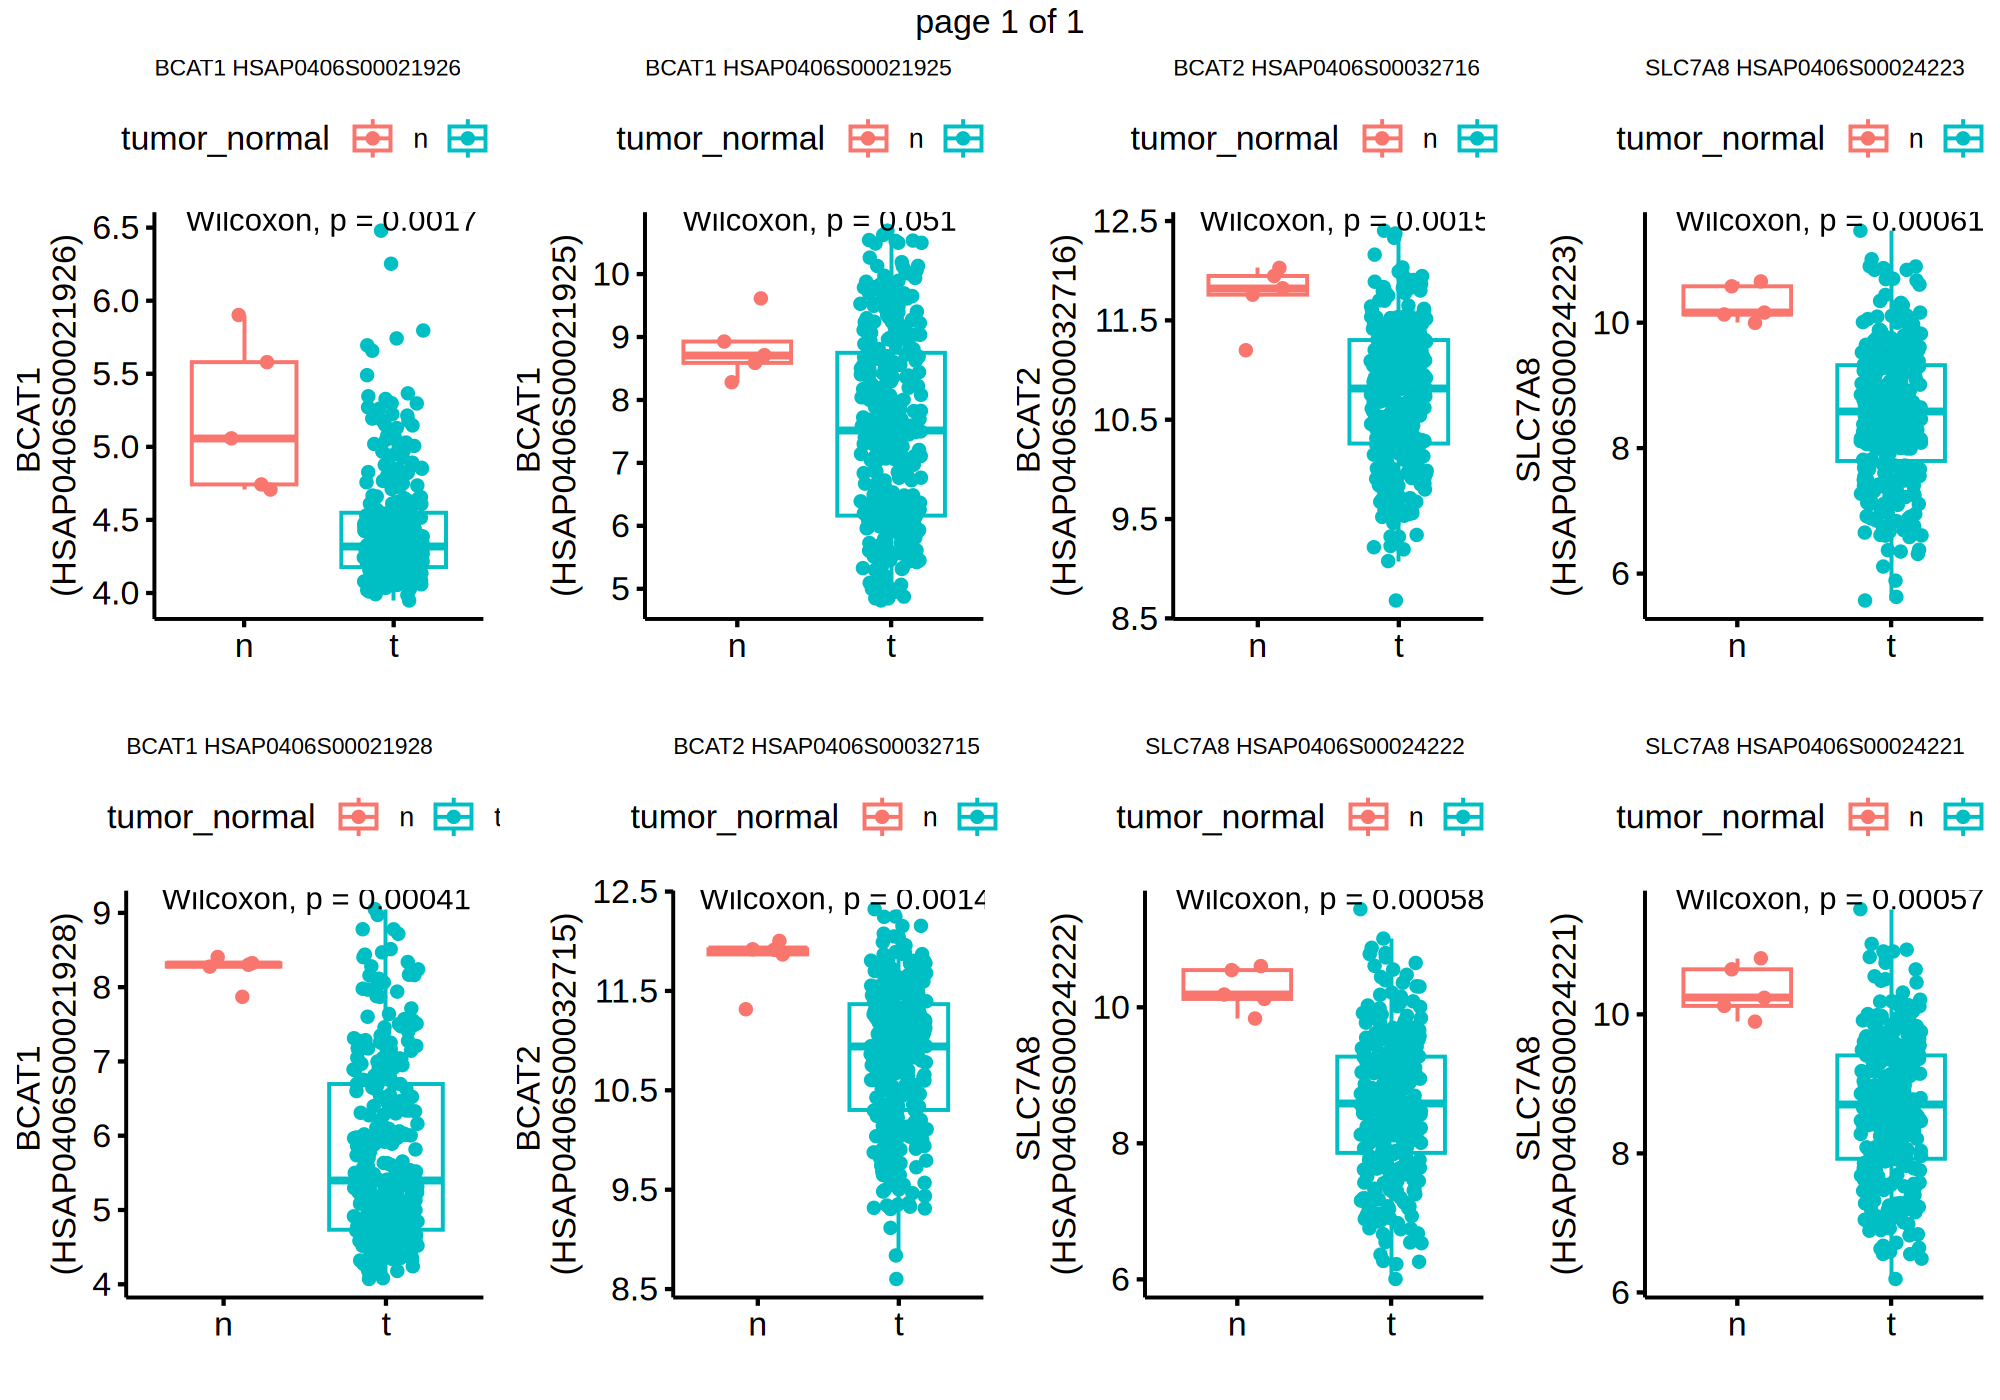

In [37]:
options(repr.plot.width = 10, repr.plot.height = 7, repr.plot.res = 200)
mut_ii = 'tumor_normal'
gg_list = lapply(1:nrow(probe_dt), function(ii){
    probe  = probe_dt[ii, NimblGen]
    symbol = probe_dt[ii, SYMBOL]
    tit = paste0(symbol, ' ', probe)
    ggboxplot(ecog_gt_dt, legend.title = mut_ii, x = mut_ii, y = probe, color = mut_ii, add = 'jitter') + 
    stat_compare_means() + xlab('') + ylab(paste0(symbol, ' \n(', probe, ')')) + ggtitle(tit) + theme(plot.title = element_text(size=8))
})
gg = gridExtra::marrangeGrob(gg_list, ncol = 4, nrow = 2)
gg


# with normal

[[1]]
NULL


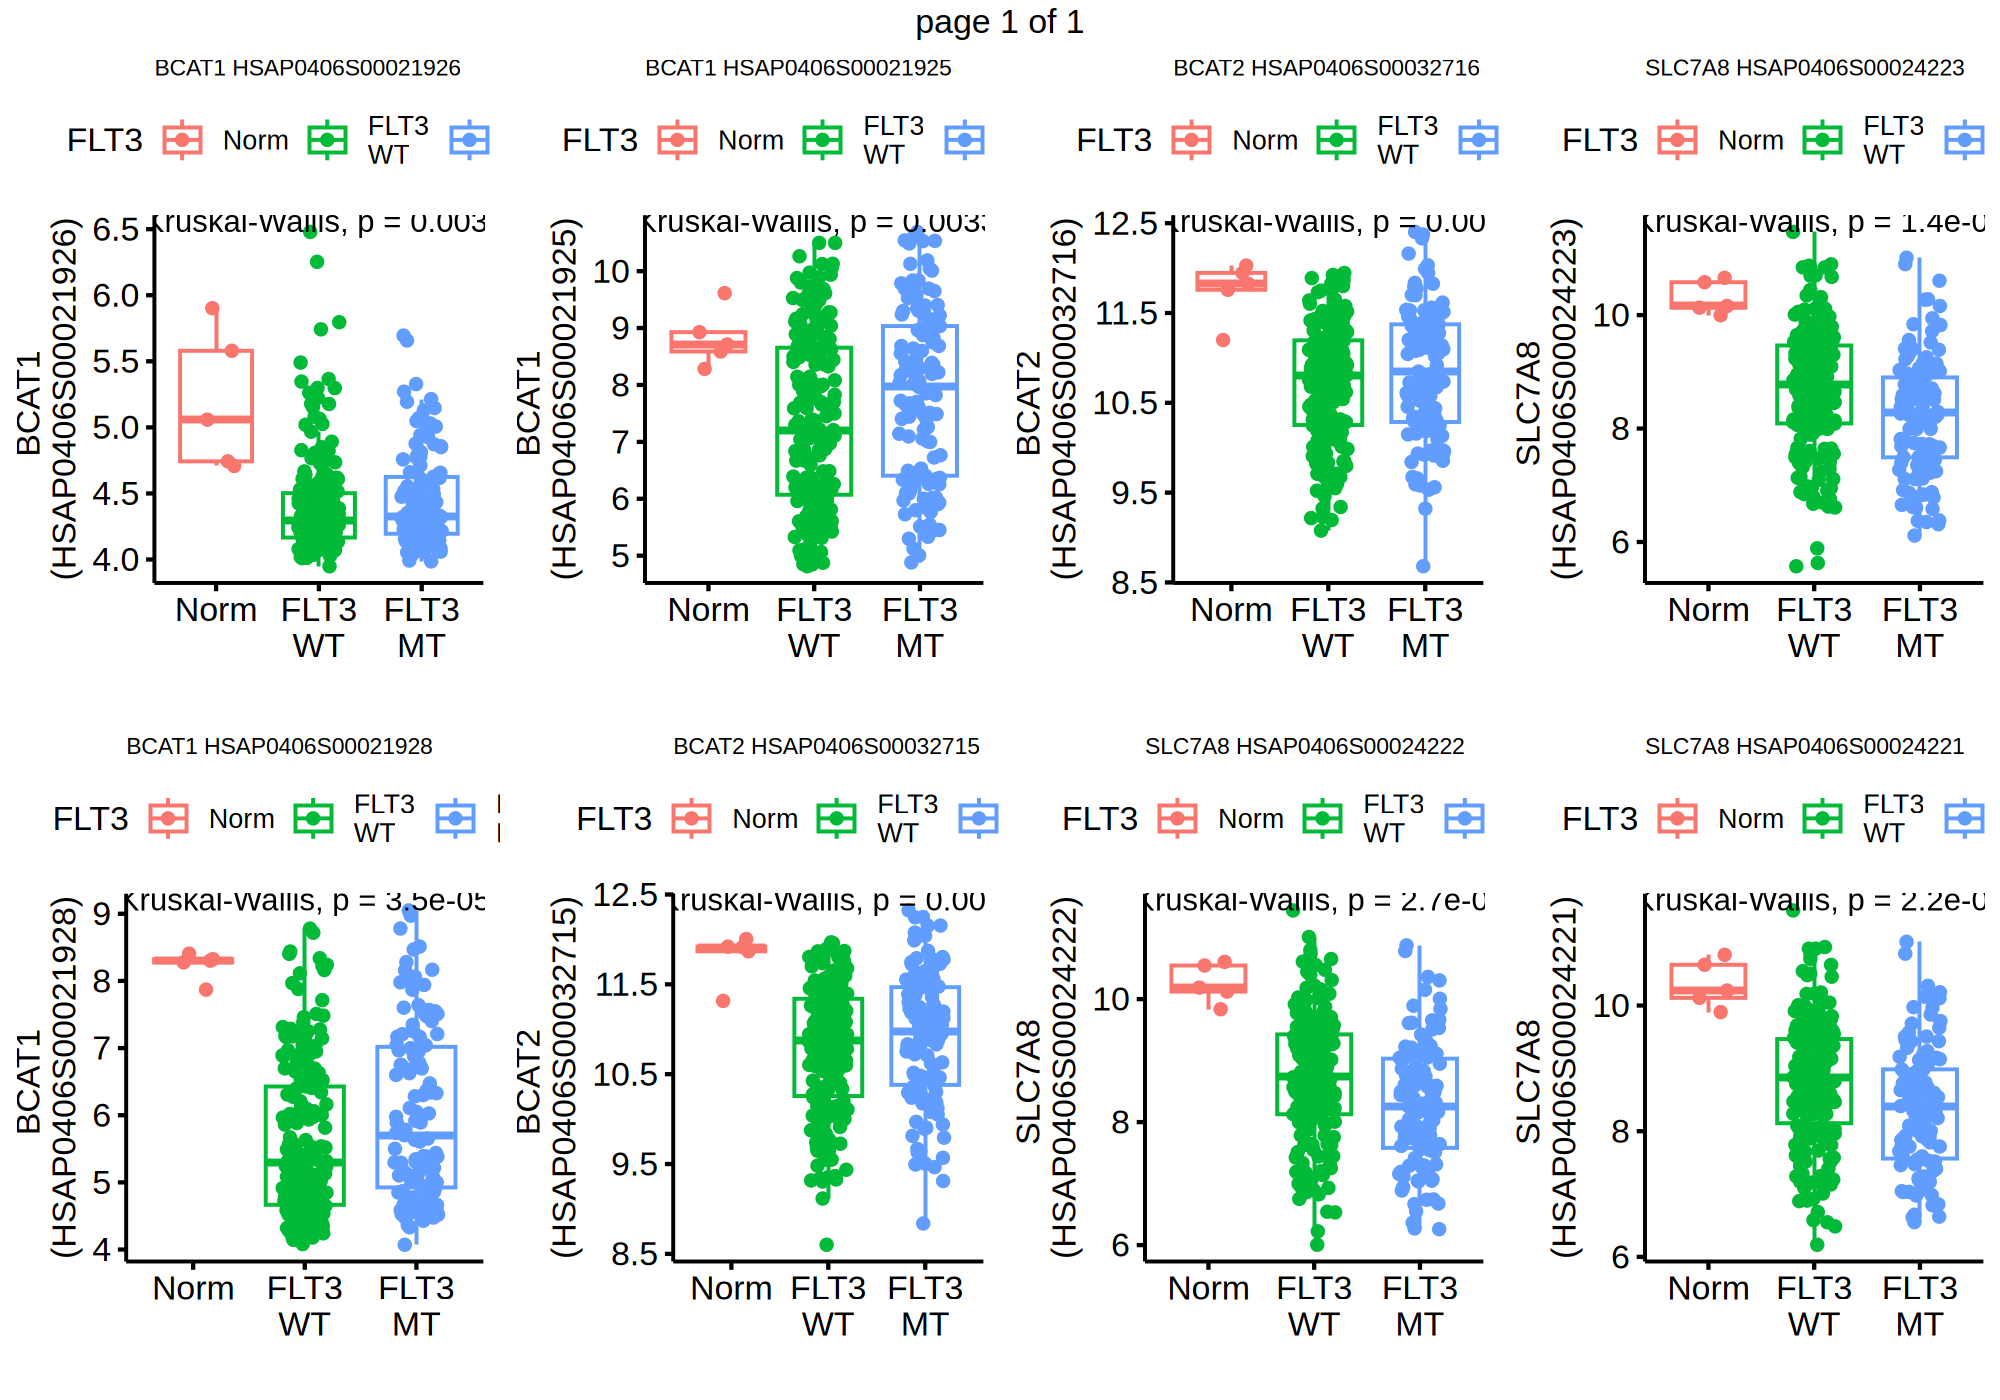

In [48]:
options(repr.plot.width = 10, repr.plot.height = 7, repr.plot.res = 200)
mut_ii = 'FLT3'
gg_list = lapply(1:nrow(probe_dt), function(ii){
    probe  = probe_dt[ii, NimblGen]
    symbol = probe_dt[ii, SYMBOL]
    tit = paste0(symbol, ' ', probe)
    ggboxplot(ecog_gt_dt, legend.title = mut_ii, x = mut_ii, y = probe, color = mut_ii, add = 'jitter') + 
    stat_compare_means() + xlab('') + ylab(paste0(symbol, ' \n(', probe, ')')) + ggtitle(tit) + theme(plot.title = element_text(size=8))
})
gg = gridExtra::marrangeGrob(gg_list, ncol = 4, nrow = 2)
gg


[[1]]
NULL


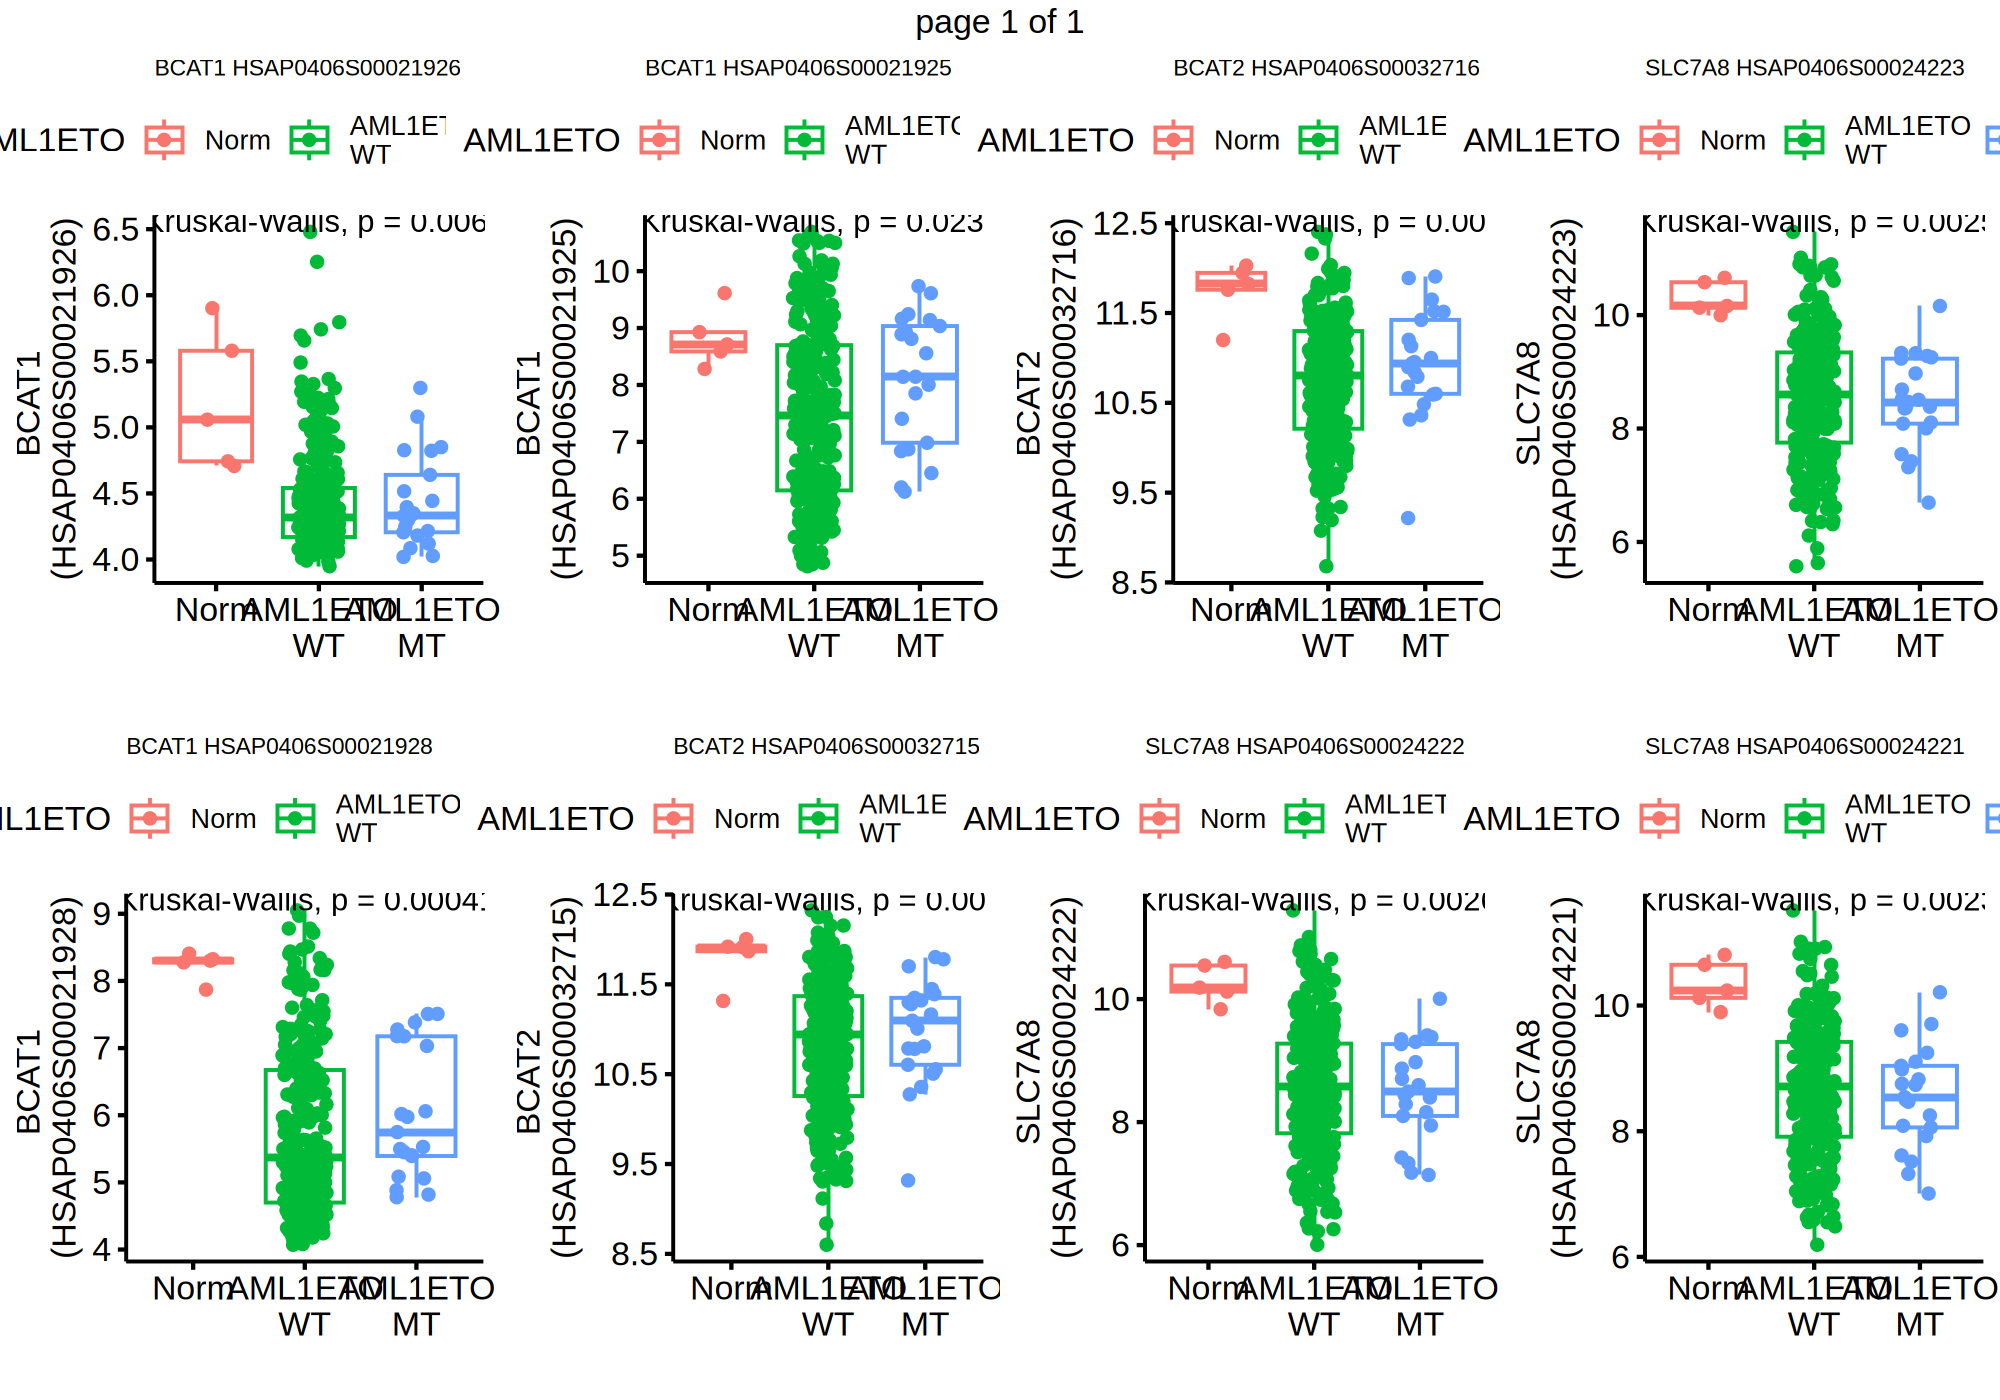

In [42]:
options(repr.plot.width = 10, repr.plot.height = 7, repr.plot.res = 200)
mut_ii = 'AML1ETO'
gg_list = lapply(1:nrow(probe_dt), function(ii){
    probe  = probe_dt[ii, NimblGen]
    symbol = probe_dt[ii, SYMBOL]
    tit = paste0(symbol, ' ', probe)
    ggboxplot(ecog_gt_dt, legend.title = mut_ii, x = mut_ii, y = probe, color = mut_ii, add = 'jitter') + 
    stat_compare_means() + xlab('') + ylab(paste0(symbol, ' \n(', probe, ')')) + ggtitle(tit) + theme(plot.title = element_text(size=8))
})
gg = gridExtra::marrangeGrob(gg_list, ncol = 4, nrow = 2)
gg


[[1]]
NULL


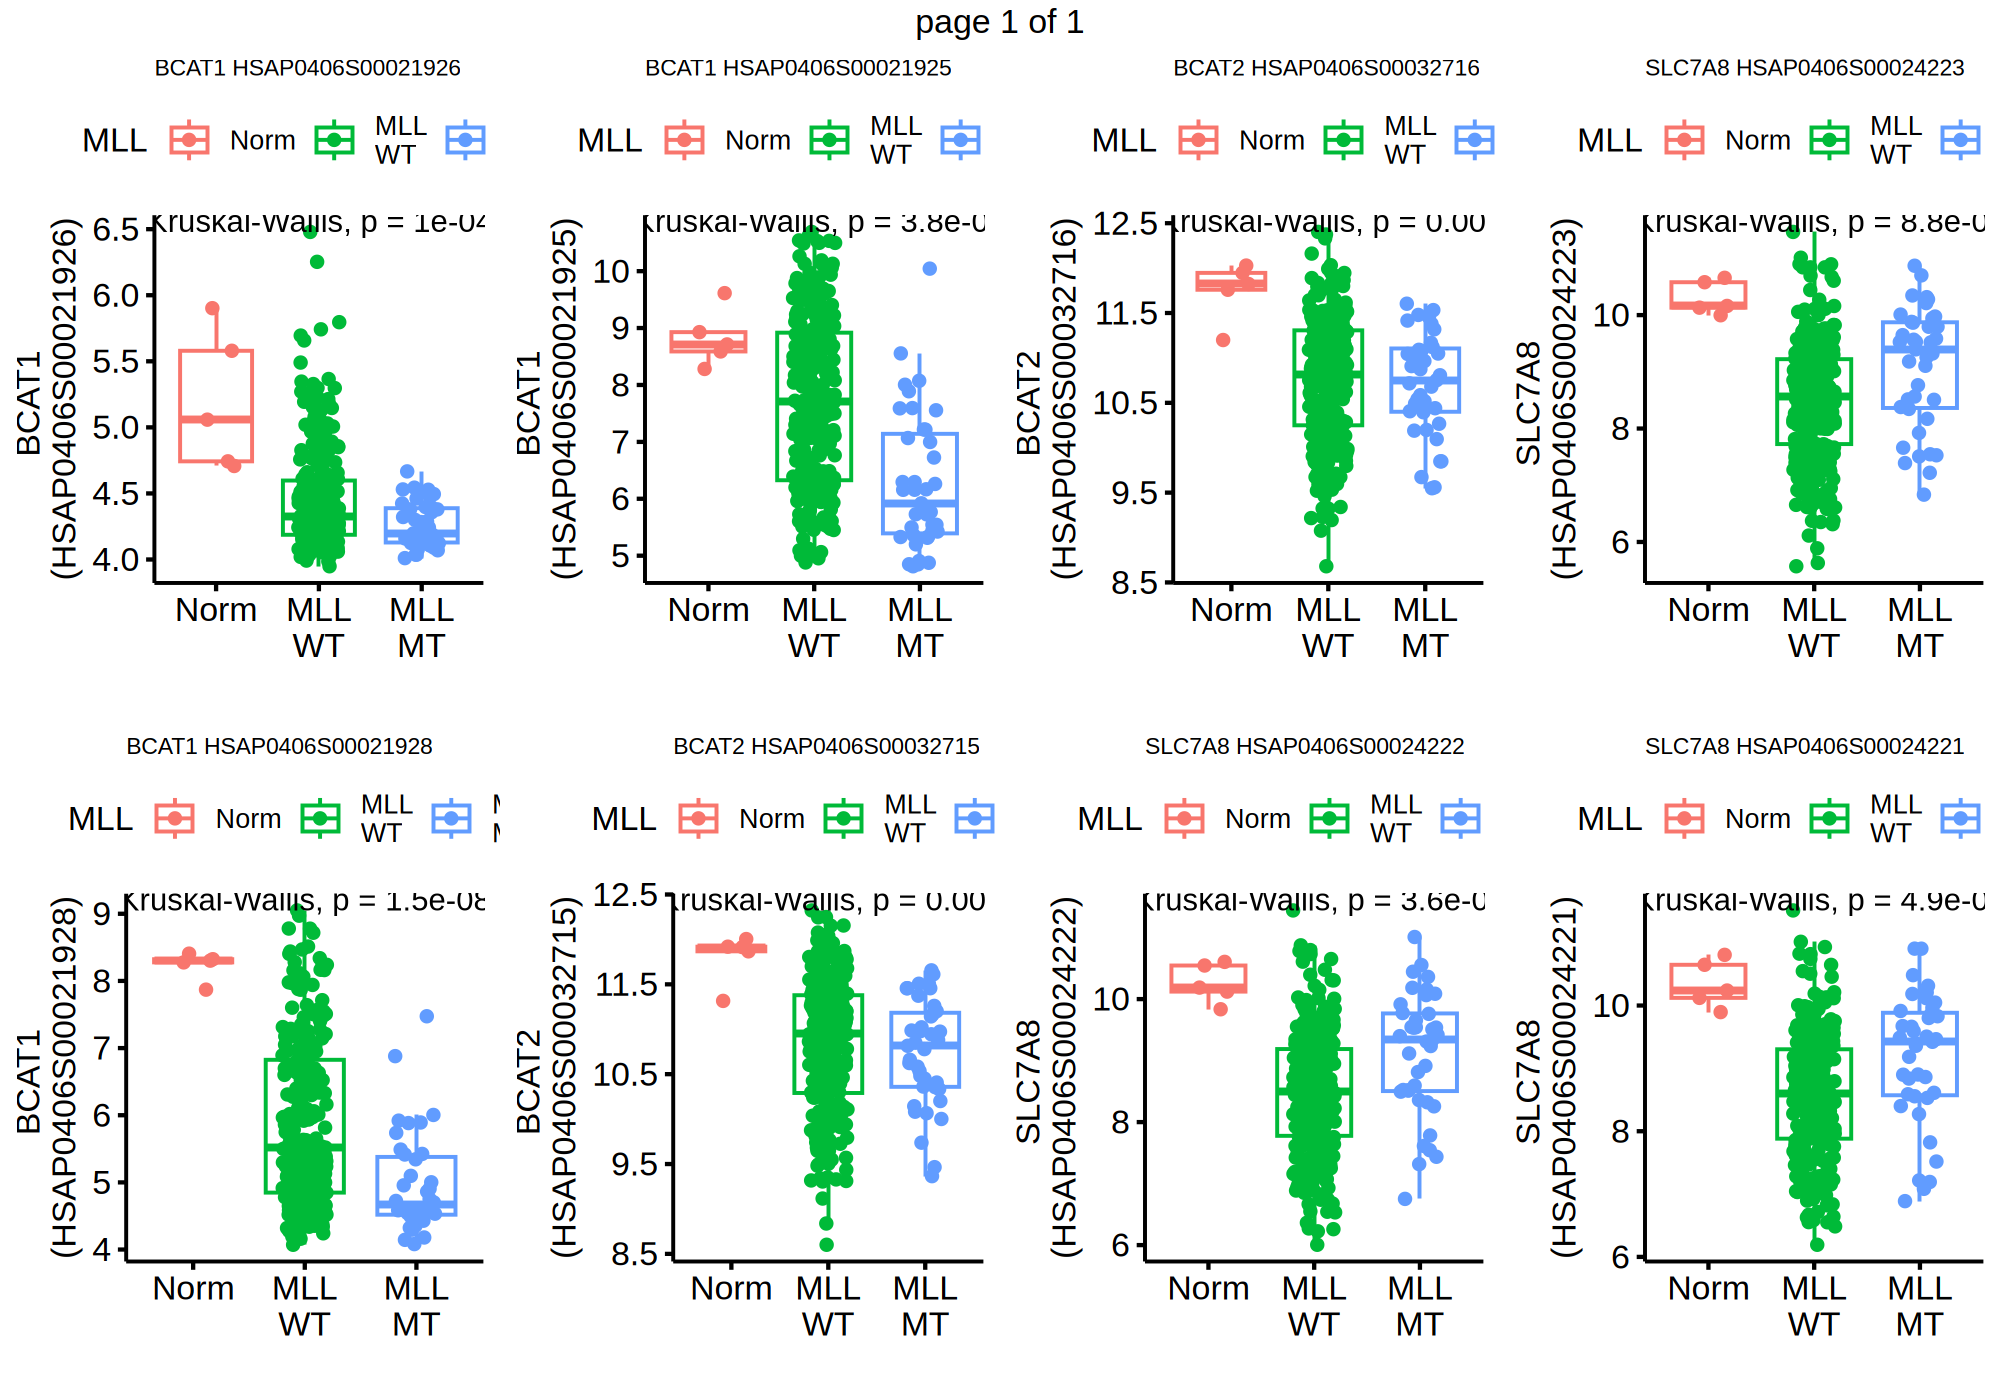

In [41]:
options(repr.plot.width = 10, repr.plot.height = 7, repr.plot.res = 200)
mut_ii = 'MLL'
gg_list = lapply(1:nrow(probe_dt), function(ii){
    probe  = probe_dt[ii, NimblGen]
    symbol = probe_dt[ii, SYMBOL]
    tit = paste0(symbol, ' ', probe)
    ggboxplot(ecog_gt_dt, legend.title = mut_ii, x = mut_ii, y = probe, color = mut_ii, add = 'jitter') + 
    stat_compare_means() + xlab('') + ylab(paste0(symbol, ' \n(', probe, ')')) + ggtitle(tit) + theme(plot.title = element_text(size=8))
})
gg = gridExtra::marrangeGrob(gg_list, ncol = 4, nrow = 2)
gg


# without normal

[[1]]
NULL


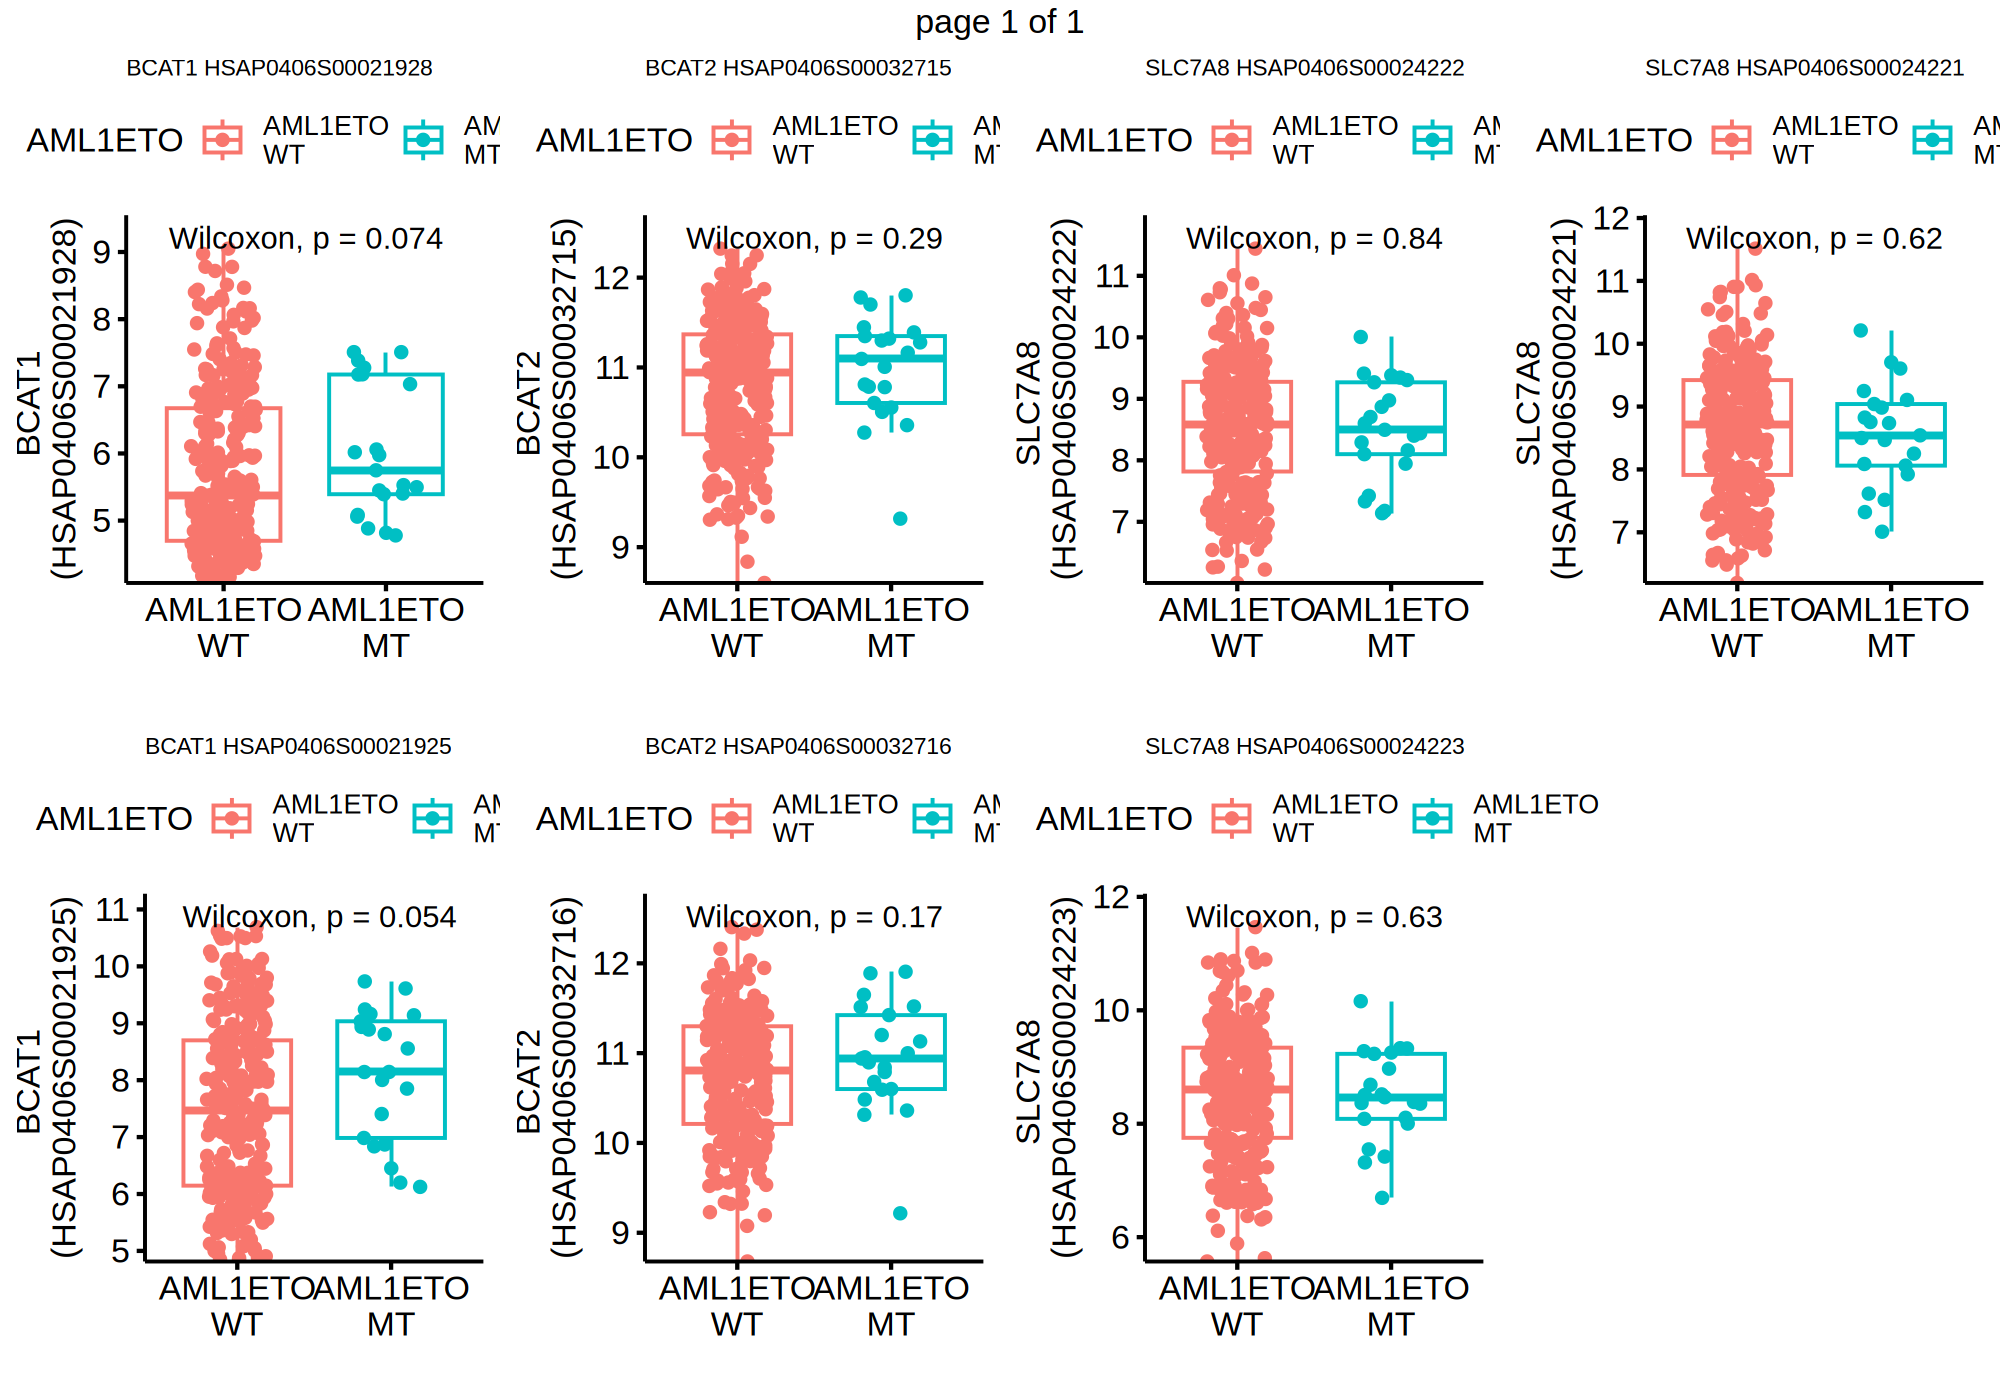

In [60]:
options(repr.plot.width = 10, repr.plot.height = 7, repr.plot.res = 200)
mut_ii = 'AML1ETO'
gg_list = lapply(1:nrow(probe_dt), function(ii){
    probe  = probe_dt[ii, NimblGen]
    symbol = probe_dt[ii, SYMBOL]
    tit = paste0(symbol, ' ', probe)
    ggboxplot(ecog_gt_dt[tumor_normal == 't',] , legend.title = mut_ii, x = mut_ii, y = probe, color = mut_ii, add = 'jitter') + 
    stat_compare_means() + xlab('') + ylab(paste0(symbol, ' \n(', probe, ')')) + ggtitle(tit) + theme(plot.title = element_text(size=8)) +
    scale_y_continuous(expand = expansion(mult = c(0, .1)))
})
gg = gridExtra::marrangeGrob(gg_list, ncol = 4, nrow = 2)
gg


[[1]]
NULL


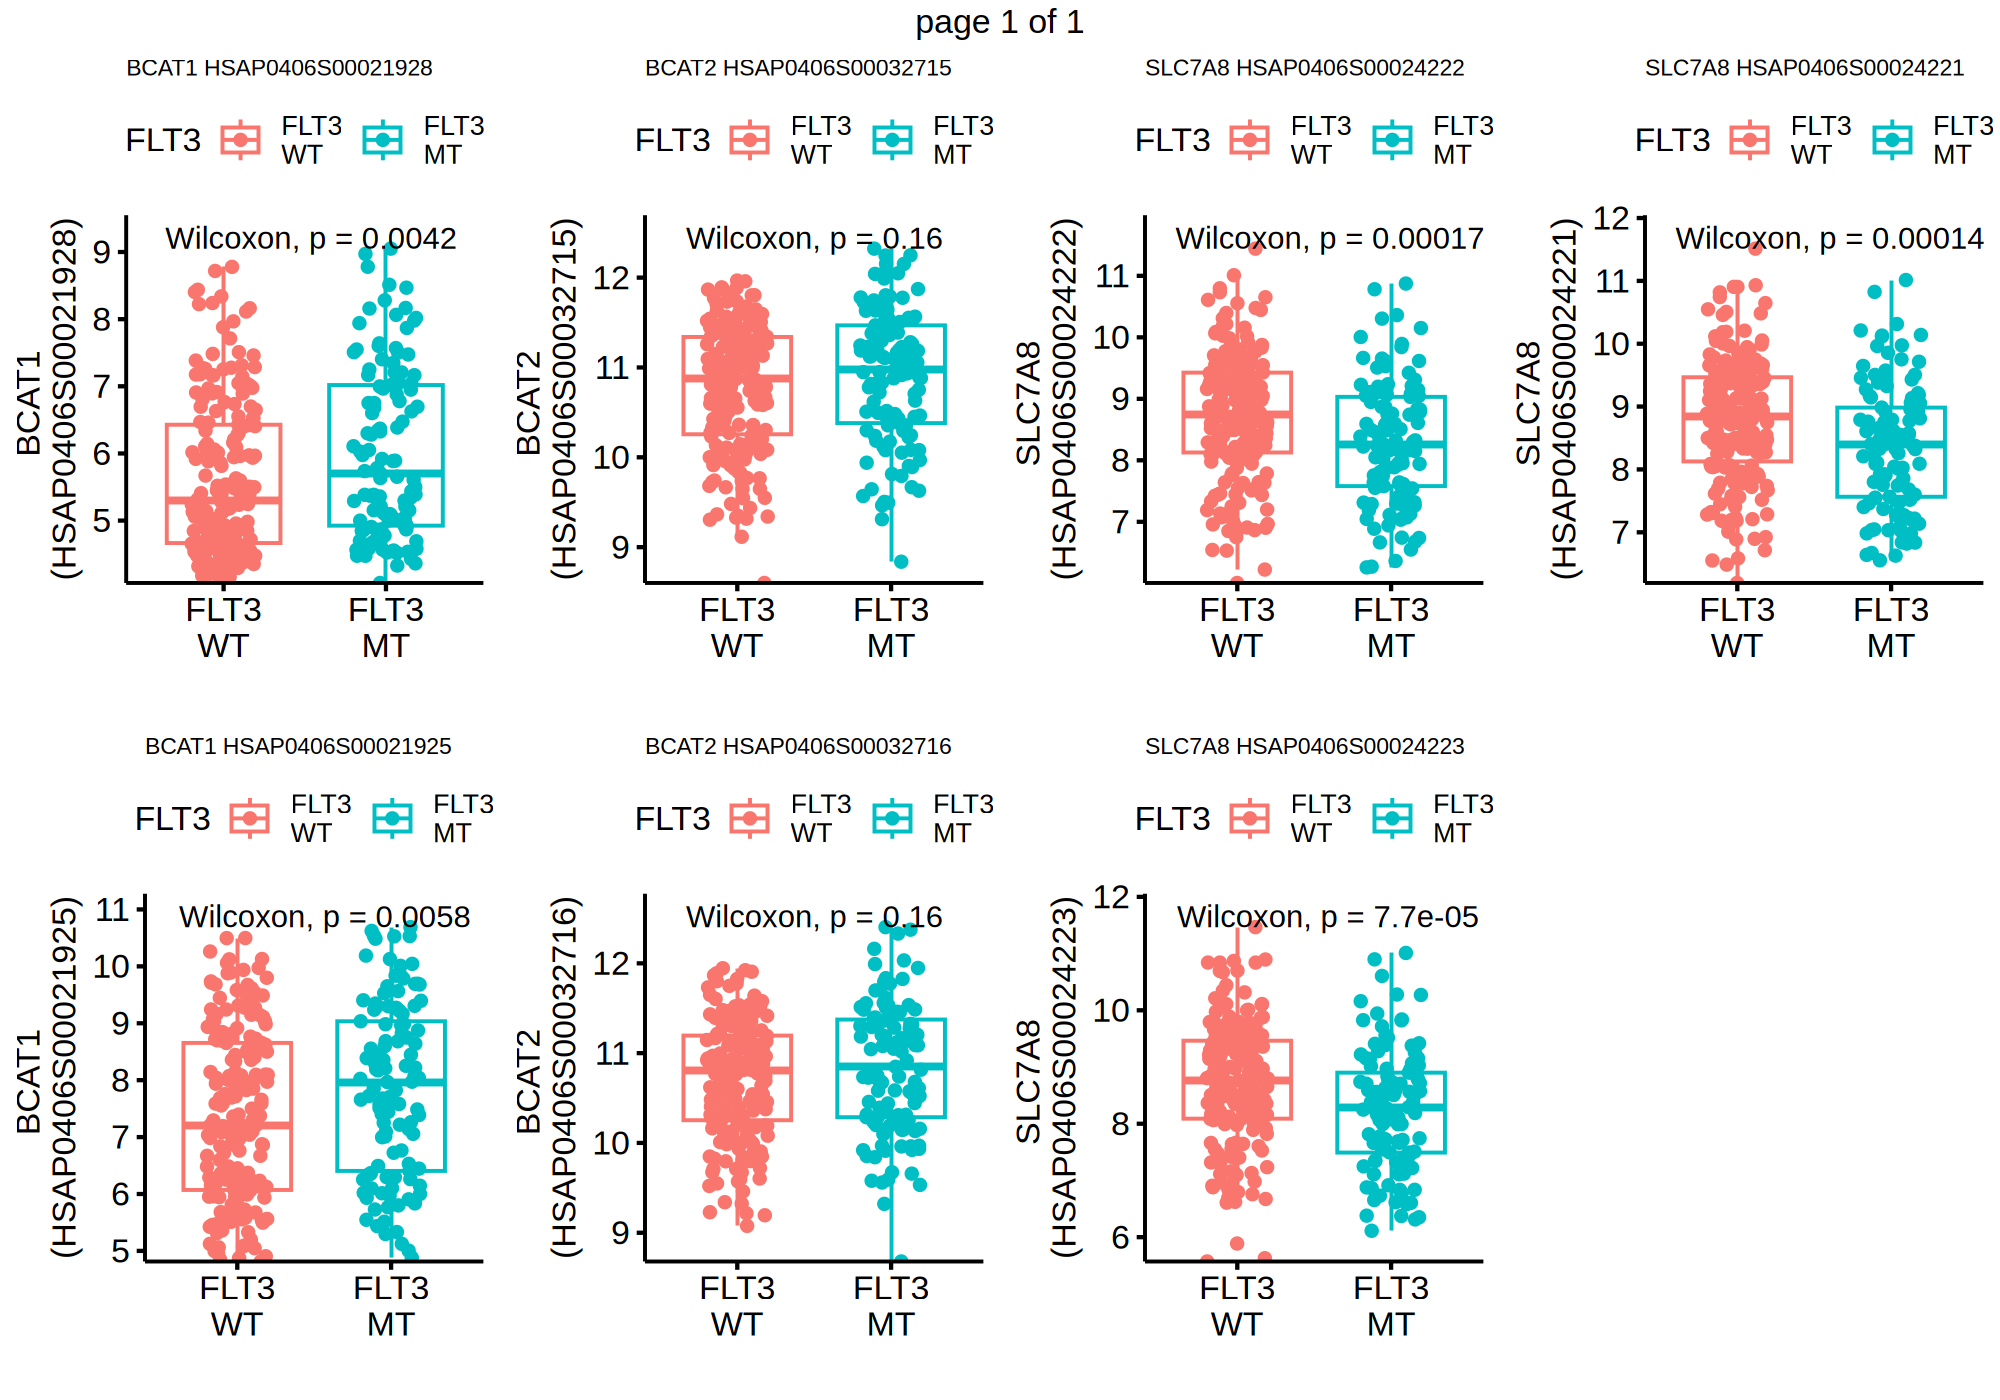

In [62]:
options(repr.plot.width = 10, repr.plot.height = 7, repr.plot.res = 200)
mut_ii = 'FLT3'
gg_list = lapply(1:nrow(probe_dt), function(ii){
    probe  = probe_dt[ii, NimblGen]
    symbol = probe_dt[ii, SYMBOL]
    tit = paste0(symbol, ' ', probe)
    ggboxplot(ecog_gt_dt[tumor_normal == 't',] , legend.title = mut_ii, x = mut_ii, y = probe, color = mut_ii, add = 'jitter') + 
    stat_compare_means() + xlab('') + ylab(paste0(symbol, ' \n(', probe, ')')) + ggtitle(tit) + theme(plot.title = element_text(size=8)) +
    scale_y_continuous(expand = expansion(mult = c(0, .1)))
})
gg = gridExtra::marrangeGrob(gg_list, ncol = 4, nrow = 2)
gg


[[1]]
NULL


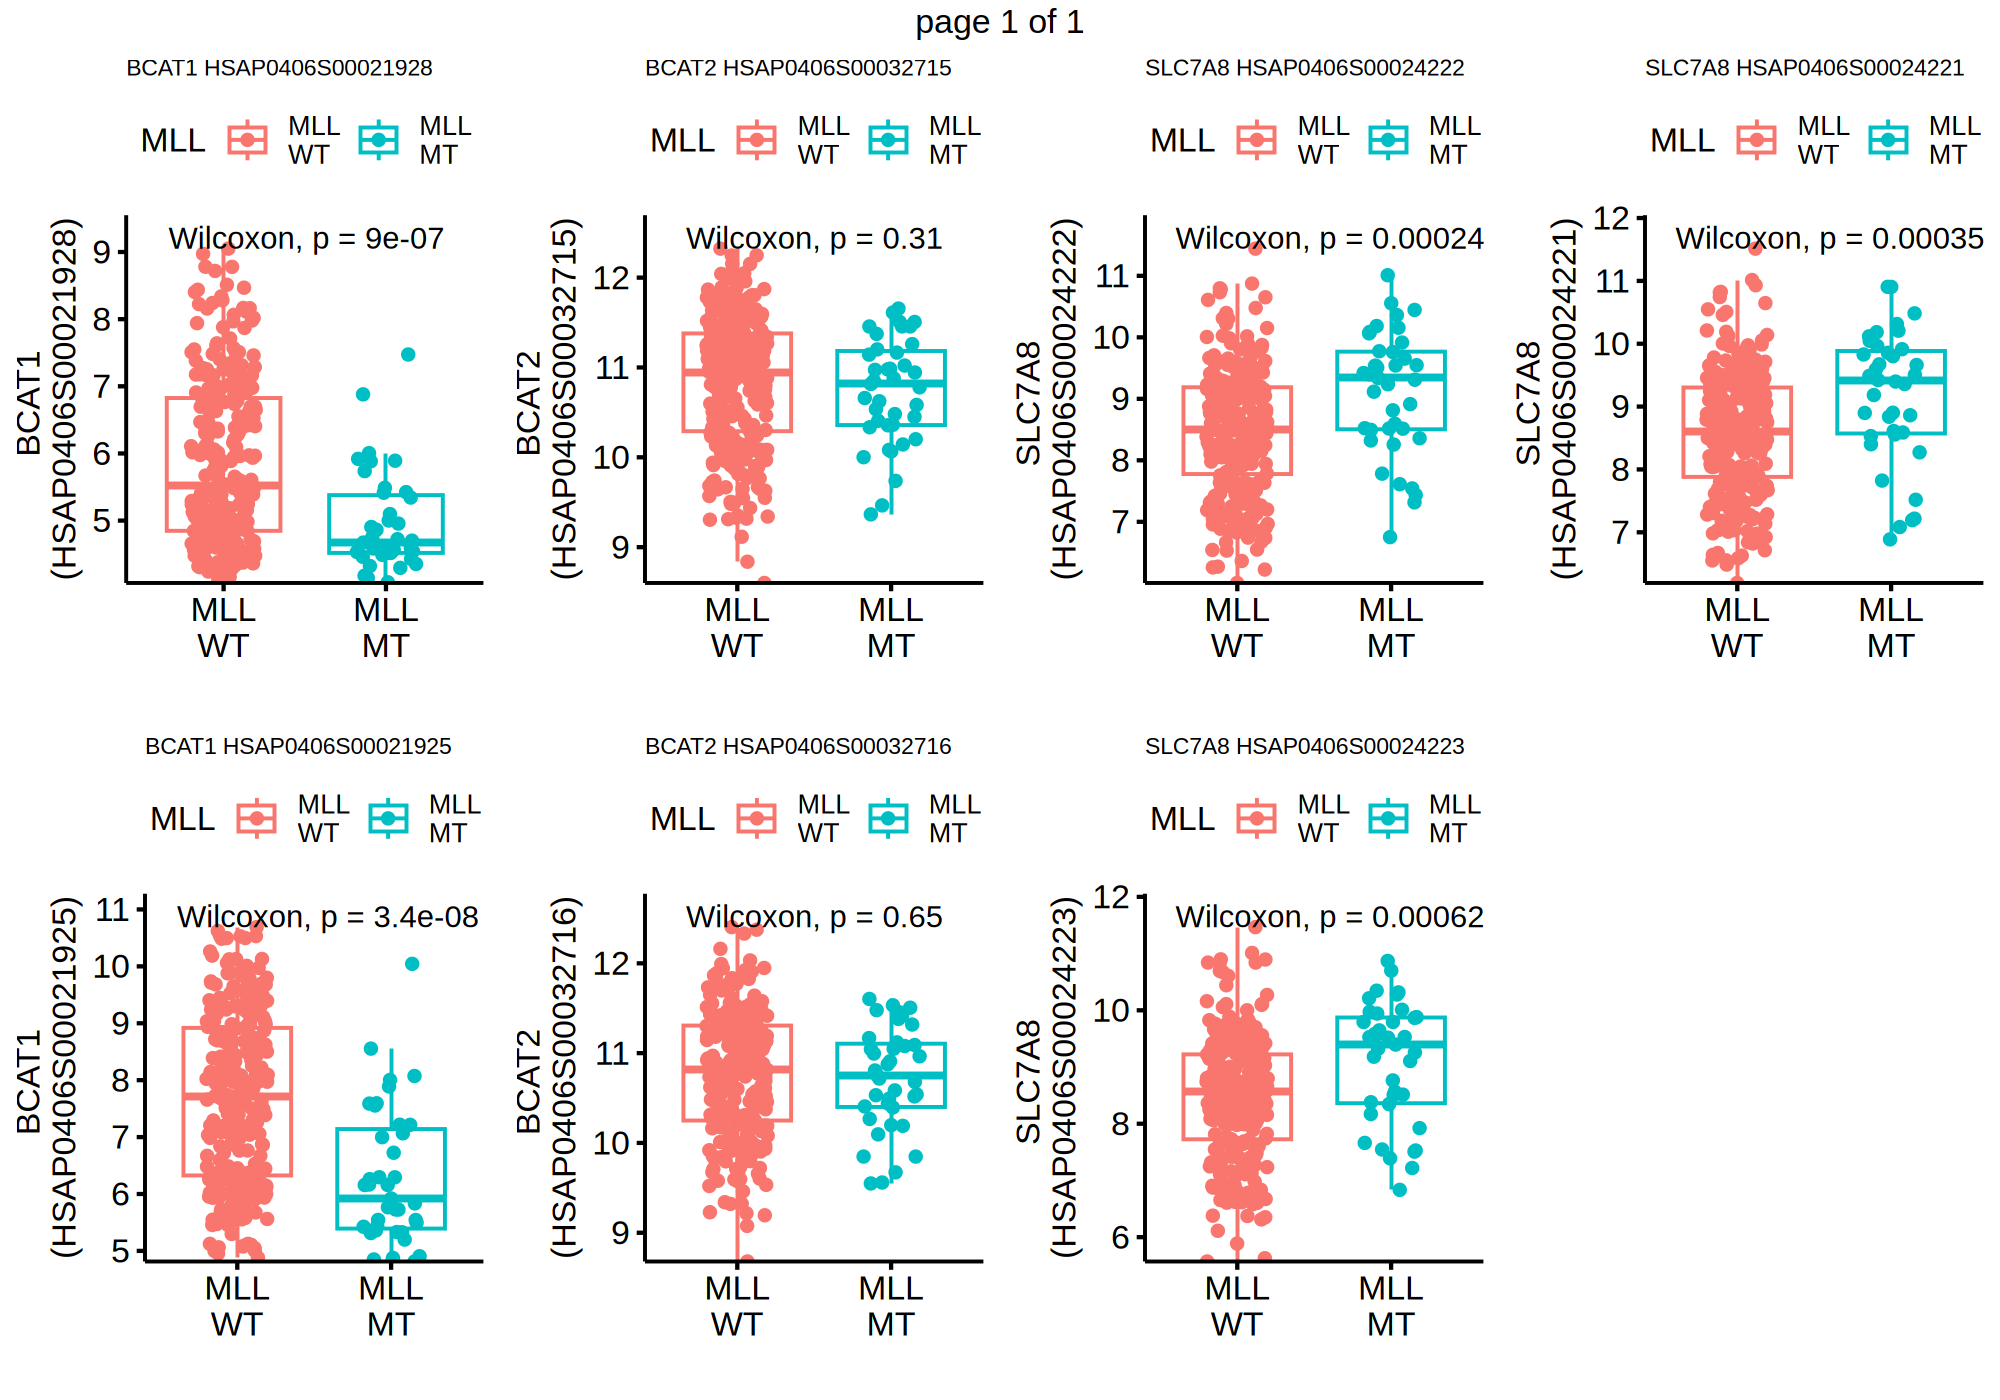

In [63]:
options(repr.plot.width = 10, repr.plot.height = 7, repr.plot.res = 200)
mut_ii = 'MLL'
gg_list = lapply(1:nrow(probe_dt), function(ii){
    probe  = probe_dt[ii, NimblGen]
    symbol = probe_dt[ii, SYMBOL]
    tit = paste0(symbol, ' ', probe)
    ggboxplot(ecog_gt_dt[tumor_normal == 't',] , legend.title = mut_ii, x = mut_ii, y = probe, color = mut_ii, add = 'jitter') + 
    stat_compare_means() + xlab('') + ylab(paste0(symbol, ' \n(', probe, ')')) + ggtitle(tit) + theme(plot.title = element_text(size=8)) +
    scale_y_continuous(expand = expansion(mult = c(0, .1)))
})
gg = gridExtra::marrangeGrob(gg_list, ncol = 4, nrow = 2)
gg


# survival analysis

In [159]:
probe_dt[, .(SYMBOL, NimblGen)]

SYMBOL,NimblGen
<chr>,<chr>
BCAT1,HSAP0406S00021928
BCAT1,HSAP0406S00021925
BCAT2,HSAP0406S00032715
BCAT2,HSAP0406S00032716
SLC7A8,HSAP0406S00024223
SLC7A8,HSAP0406S00024221


In [70]:
ecog_dt = fread('~/ecog/ecog1900_expression_outcomes.txt')
ecog_dt[, idd := 1:nrow(ecog_dt)]

ecog_surv_dt = ecog_dt[6:nrow(ecog_dt), ]
ecog_surv_dt[DFSStat == '?', DFSStat := NA]
ecog_surv_dt[DFS == '?', DFS := NA] 
ecog_surv_dt[, DFSStat := as.numeric(DFSStat)] 
ecog_surv_dt[, DFS := as.numeric(DFS)] 
ecog_surv_dt[, EFSStat := as.numeric(EFSStat)] 
ecog_surv_dt[, EFS := as.numeric(EFS)] 
ecog_surv_dt[, OSStat := as.numeric(OSStat)] 
ecog_surv_dt[, OS := as.numeric(OS)] 


here

here

here

here

here

here



[[1]]
NULL

[[2]]
NULL

[[3]]
NULL

[[4]]
NULL

[[5]]
NULL

[[6]]
NULL

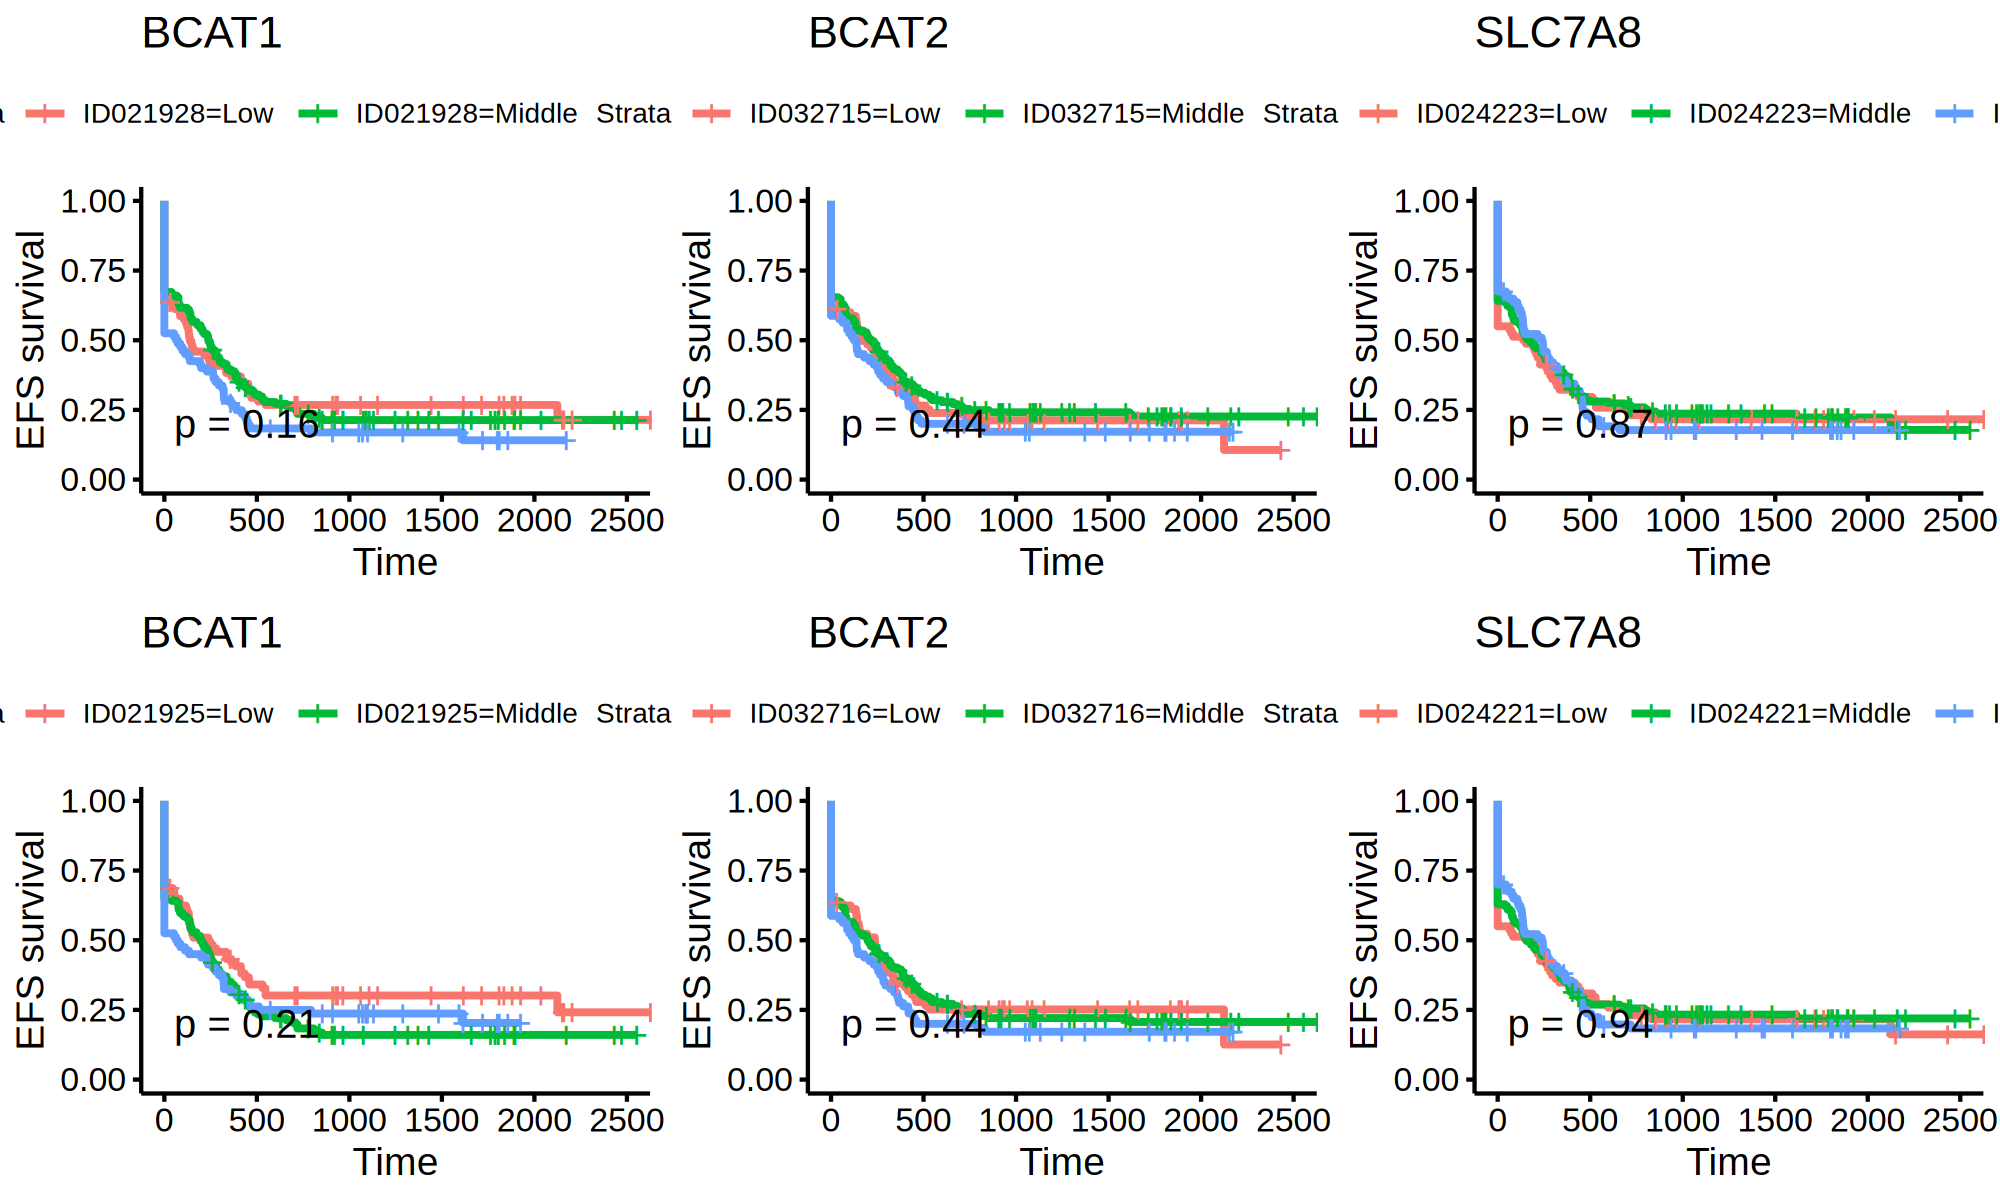

In [204]:
probe_dt[, quant_name := paste0('ID', substring(NimblGen, 12, 17))] 
probe_dt[, tit := paste0(SYMBOL, '\n', NimblGen, '')] 

lapply(1:nrow(probe_dt), function(ii){
    gene = probe_dt[ii, SYMBOL]
    pid = probe_dt[ii, NimblGen]
    var_name = probe_dt[ii, quant_name]
    gene_var = unlist(ecog_surv_dt[, pid, with = F])
    ecog_surv_dt[, (var_name) := factor(findInterval(gene_var, c(-Inf, quantile(gene_var, probs=c(0.25, .75)),  Inf)), 
                                        labels=c("Low", "Middle", "High") ) ]
})

forms = paste0('Surv(EFS, EFSStat) ~ ', probe_dt$quant_name)
ff_list = lapply(forms, as.formula)
my_fits = surv_fit(ff_list, data = ecog_surv_dt)
ggsurvs = ggsurvplot_list(my_fits, risk.table = F, pval = TRUE, data = ecog_surv_dt, title = probe_dt$SYMBOL, ylab = 'EFS survival')
names(ggsurvs) = probe_dt$SYMBOL

options(repr.plot.width = 10, repr.plot.height = 6, repr.plot.res = 200)
arrange_ggsurvplots(ggsurvs, nrow = 2, ncol = 3)


In [271]:
options(repr.plot.width = 4, repr.plot.height = 5.5, repr.plot.res = 200)
fit <- survfit(Surv(OS, OSStat) ~ quartile, data = ecog_surv_dt[quantile %in% ('Low', 'High'), ])
ggsurvplot(fit,   conf.int = TRUE,          # Add confidence interval
  pval = TRUE,              # Add p-value
  risk.table = TRUE,        # Add risk table
  risk.table.col = "strata",# Risk table color by groups
  legend.labs = c("Low", "Middle", "High"),    # Change legend labels
  risk.table.height = 0.25, # Useful to change when you have multiple groups
  ggtheme = theme_pubr()   )   # Change ggplot2 theme


ERROR: Error in parse(text = x, srcfile = src): <text>:2:85: unexpected ','
1: options(repr.plot.width = 4, repr.plot.height = 5.5, repr.plot.res = 200)
2: fit <- survfit(Surv(OS, OSStat) ~ quartile, data = ecog_surv_dt[quantile %in% ('Low',
                                                                                       ^


In [ ]:
fit <- survfit(Surv(OS, OSStat) ~ quartile, data = ecog_surv_dt)
ggsurvplot(
  fit,
  data = lung,
  size = 1,                 # change line size
  palette =
    c("#E7B800", "#2E9FDF"),# custom color palettes
  conf.int = TRUE,          # Add confidence interval
  pval = TRUE,              # Add p-value
  risk.table = TRUE,        # Add risk table
  risk.table.col = "strata",# Risk table color by groups
  legend.labs =
    c("Male", "Female"),    # Change legend labels
  risk.table.height = 0.25, # Useful to change when you have multiple groups
  ggtheme = theme_bw()      # Change ggplot2 theme
)
 

In [ ]:

setwd('~/gdrive/huw/chung/ecog/')
 
library(org.Hs.eg.db)
 
 
gpl = fread("GPL6602-433.txt", header=T)
setnames(gpl, 'ID', 'NimblGen')
#colnames(gpl) = c('NimblGen', 'ACCNUM')
 
res = select(org.Hs.eg.db, keys=gpl$GB_ACC, columns=c("SYMBOL", "GENENAME", "ENSEMBL", "ACCNUM"), keytype="ACCNUM")
head(res)
dim(res)
gpl.id = merge(gpl, res, by.x = 'GB_ACC', by.y = "ACCNUM")
#gpl.id[SYMBOL == 'BCAT2',]
# SLC7A5 (LAT1), SLC3A2, SLC16A19, SLC16A1 (MCT1), SLC16A3 (MCT4), SLC25A44
genes = c('SLC7A5', 'SLC3A2', 'SLC16A19', 'SLC16A1', 'SLC16A3', 'SLC25A44')
gpl.id[SYMBOL %in% genes, ]
id = unique(gpl.id[SYMBOL %in% genes, NimblGen])
id
 
ecog.dt = fread('ecog1900_expression_outcomes.txt')
# genotype mutation
ecog.dt[1:10, 1:33]
# clinical information
ecog.dt[1:10, 34:59]
# gene expression, NimbelGen
ecog.dt[1:10, 60:89]
table(ecog.dt$tumor_normal)
 
mtx.1 = ecog.dt[6:324, 5:8]
mtx.2 = ecog.dt[6:324, 9:39]
mtx.3 = ecog.dt[6:324, id, with=F]
mtx = cbind(mtx.1, mtx.2, mtx.3)
mtx[1:10, ]
mtx.3[1:10, ]
 
lapply(genes, function(gene){genex.fun(gene, gpl.id = gpl.id, ecog.dt = ecog.dt)})
 
genex.fun = function(genex, gpl.id = gpl.id, ecog.dt = ecog.dt, fname.pre = NULL){
 
                if(is.null(fname.pre)){ fname.pre = paste0(getwd(), '/ecog') }
 
                probe.id = unique(gpl.id[SYMBOL == genex, NimblGen])
                if(length(probe.id) == 0){
                                message('No genes found for gene ', genex)
                                return(0)}
                probe.id
                tmp = ecog.dt[6:324, 9:39]
                tmp[1:10, ]
                for(ii in colnames(tmp)){
                                tmp[get(ii) != 'WT', (ii) := 'MT']
                                tmp[, (ii) := factor(get(ii), levels = c('WT', 'MT'))]
                }
                tmp2 = cbind(tmp, ecog.dt[6:324, probe.id, with=F])
                tmp2[1:10, ]
                tmp2
 
                genotype.genes = colnames(tmp2)[1:31]
                genotype.genes
                gg.list = list()
                for(genotype.gene in genotype.genes){
                                gg = lapply(probe.id, function(xx){ ggboxplot(tmp2, legend.title = genotype.gene,
                                                                                                                      x = genotype.gene, y = xx, color = genotype.gene, add = 'jitter') +
                                                    stat_compare_means() + xlab(genotype.gene) })
                                gg.list = c(gg.list, gg)
                }
 
                gg = gridExtra::marrangeGrob(gg.list, ncol=6, nrow=length(probe.id), as.table = FALSE)
                fname = paste0(fname.pre, '_', genex, '.pdf'); fname
                cat('plotting ', fname, '\n')
                ggplot2::ggsave(gg, file=fname, width=13, height=3*length(probe.id))
 
}
 
 
## BCAT1
 
{
 
                genex = 'BCAT1'
                probe.id = unique(gpl.id[SYMBOL == genex, NimblGen])
                tmp = ecog.dt[6:324, 9:39]
                tmp[1:10, ]
                for(ii in colnames(tmp)){
                                tmp[get(ii) != 'WT', (ii) := 'MT']
                                tmp[, (ii) := factor(get(ii), levels = c('WT', 'MT'))]
                }
                tmp2 = cbind(tmp, ecog.dt[6:324, id, with=F])
                tmp2[1:10, ]
                tmp2
 
                genes = colnames(tmp2)[1:31]
                genes
                gg.list = list()
                for(gene in genes){
                                tmp = lapply(probe.id, function(xx){ ggboxplot(tmp2, legend.title = gene, x = gene, y = xx, color = gene, add = 'jitter') + stat_compare_means() + xlab(gene) })
                                gg.list = c(gg.list, tmp)
                }
 
                gg = gridExtra::marrangeGrob(gg.list, ncol=6, nrow=length(probe.id), as.table = FALSE)
                fname = paste0('res/all_', genex, '.pdf'); fname
                cat('plotting ', fname, '\n')
                ggplot2::ggsave(gg, file=fname, width=13, height=3*length(probe.id))
 
}
 
 
# BCAT2
{
 
                genex = 'BCAT2'
                probe.id = unique(gpl.id[SYMBOL == genex, NimblGen])
                tmp = ecog.dt[6:324, 9:39]
                tmp[1:10, ]
                for(ii in colnames(tmp)){
                                tmp[get(ii) != 'WT', (ii) := 'MT']
                                tmp[, (ii) := factor(get(ii), levels = c('WT', 'MT'))]
                }
                tmp2 = cbind(tmp, ecog.dt[6:324, id, with=F])
                tmp2[1:10, ]
                tmp2
 
                genes = colnames(tmp2)[1:31]
                genes
                gg.list = list()
                for(gene in genes){
                                tmp = lapply(probe.id, function(xx){ ggboxplot(tmp2, legend.title = gene, x = gene, y = xx, color = gene, add = 'jitter') + stat_compare_means() + xlab(gene) })
                                gg.list = c(gg.list, tmp)
                }
 
                gg = gridExtra::marrangeGrob(gg.list, ncol=6, nrow=length(probe.id), as.table = FALSE)
                fname = paste0('res/all_', genex, '.pdf'); fname
                cat('plotting ', fname, '\n')
                ggplot2::ggsave(gg, file=fname, width=13, height=3*length(probe.id))
 
}
 
save.image()
 
fit <- survfit(Surv(OS, OSStatus) ~ sex, data = ecog.dt)
 
 
ggsurvplot(
  fit,
  data = lung,
  size = 1,                 # change line size
  palette =
    c("#E7B800", "#2E9FDF"),# custom color palettes
  conf.int = TRUE,          # Add confidence interval
  pval = TRUE,              # Add p-value
  risk.table = TRUE,        # Add risk table
  risk.table.col = "strata",# Risk table color by groups
  legend.labs =
    c("Male", "Female"),    # Change legend labels
  risk.table.height = 0.25, # Useful to change when you have multiple groups
  ggtheme = theme_bw()      # Change ggplot2 theme
)
 

In [ ]:
ecog1900_dt.tsv